In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input\movielens-fds\movielens-fds.zip
kaggle/input\movielens-fds\sample_submission.csv
kaggle/input\movielens-fds\test.csv
kaggle/input\movielens-fds\training.csv


In [3]:
def evaluate(predict_f,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)


def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.05)),
                                   replace=False)
    df['for_testing'] = False
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [9]:
df = pd.read_csv('kaggle/input/movielens-fds/training.csv',index_col=0)


grouped    = df.groupby('user_id', group_keys=False).apply(assign_to_set)
df_train = df[grouped.for_testing == False]
df_val   = df[grouped.for_testing == True]

df.head()

,user_id,movie_id,rating,title,genre
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,6,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,56,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,71,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
4,84,307,3.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


In [7]:
df_test = pd.read_csv('kaggle/input/movielens-fds/test.csv',index_col=0)
df_test.head()

,user_id,movie_id,title,genre
0,1762,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,1762,67534,Big Stan (2007),Comedy
2,1762,2317,"Alarmist, The (a.k.a. Life During Wartime) (1997)",Comedy
3,1762,94011,"Big Bang, The (2011)",Action|Thriller
4,1762,164725,The Cheetah Girls 2 (2006),Children|Comedy|Drama


In [5]:
from scipy import sparse


class RecSys_vanilla_mf_biases():
    """ Collaborative filtering using a custom sim(u,u'). """

    def __init__(self,df_train,df_val, num_components=10):
        """ Constructor """
        self.df_train = df_train
        self.df_val = df_val
        self.num_components=num_components
        self.train = pd.pivot_table(self.df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.train.index))
        self.users = dict(zip(user_index,self.train.index ))
        self.users_id2index = dict(zip(self.train.index,user_index)) 
        
        movie_index = np.arange(len(self.train.columns))
        self.movies = dict(zip(movie_index,self.train.columns )) 
        self.movies_id2index= dict(zip(self.train.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.train.columns))
        self.movie_id2title = dict(df.groupby(by=['movie_id','title']).count().index)
    
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
                
                
    def fit(self,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.ratings = np.float32(self.train.fillna(0).values)
        self.mean_rating = self.ratings[self.ratings>0].mean() 
        self.n_users, self.n_items = self.train.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(self.predict,self.df_train))
            self.test_rmse.append(evaluate(self.predict,self.df_val))
            
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        if(user_id in self.users_id2index):
            user_index = self.users_id2index[user_id]
        else:
            return 3 #cold start user
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
    

In [7]:
np.sqrt(0.89999)

0.9486780275731066

Epoch: 0
	Train rmse: 0.9151188055992497
	Test rmse: 0.9362395269544618
Epoch: 1
	Train rmse: 0.9028736088528077
	Test rmse: 0.9259989780488569
Epoch: 2
	Train rmse: 0.8971299009032024
	Test rmse: 0.9216920915040308
Epoch: 3
	Train rmse: 0.8938340844867382
	Test rmse: 0.9196295975213885
Epoch: 4
	Train rmse: 0.8914311620632174
	Test rmse: 0.9178114779031569


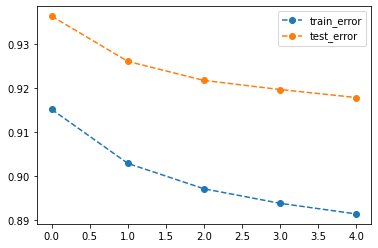

RMSE for Collaborative Recomender: 0.9178114779031569


In [6]:
reco = RecSys_vanilla_mf_biases(df_train,df_val,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.01,lmbda=0.5)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,df_val))

In [7]:
#estimate all pairs of user_id/movie_id from the test set
ids_to_estimate = zip(df_test.user_id, df_test.movie_id)
estimated = np.array([reco.predict(u,i) for (u,i) in ids_to_estimate ])

# generate the submission file
df_test['estimated'] = estimated
df_test.sort_values(by='estimated',ascending=False)[['user_id','movie_id']].to_csv('baseline_submision.csv',index=None)